In [1]:
import os
import config
import platform
v1, v2, v3 = config.spark_env(platform.node())
os.environ['SPARK_VERSION'] = v1
os.environ['JAVA_HOME'] = v2
os.environ['SPARK_HOME'] = v3
import findspark
import pyspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("emissionsdataframe").getOrCreate()
from sqlalchemy import create_engine, insert
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, update, Table
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import array, col, explode, lit, struct, log
from pyspark.sql import DataFrame
from typing import Iterable
import numpy as np
import spark_functions
import tensorflow as tf
import keras.metrics
import pyspark.sql.functions as F
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
rds_string = config.rds_string
engine = create_engine(f'postgresql://{rds_string}')
conn = engine.connect()
metadata = MetaData(engine)

In [9]:
india_spark, india_cols = spark_functions.merged_df("India")

In [10]:
china_spark, china_cols = spark_functions.merged_df("China")

In [11]:
germany_spark, germany_cols = spark_functions.merged_df("Germany")

In [12]:
france_spark, france_cols = spark_functions.merged_df("France")

In [13]:
mexico_spark, mexico_cols = spark_functions.merged_df("Mexico")

In [14]:
us_spark, us_cols = spark_functions.merged_df("United States")

In [26]:
def unions_spark(dfs):
    steve = len(dfs)
    df = dfs[0]
    for i in range(steve - 1):
        df = df.union(dfs[i+1])
    return df

In [32]:
dfs = [india_spark,china_spark,mexico_spark,us_spark, germany_spark, france_spark]

In [33]:
dfs[0]

DataFrame[country: string, year: int, gdp: double, annual_co2_emissions_tonnes_log: double, import_trade_sum_usd_log: double, import_weight_sum_kg_log: double, import_quantity_sum_log: double, export_trade_sum_usd_log: double, export_weight_sum_kg_log: double, export_quantity_sum_log: double]

In [36]:
df = unions_spark(dfs)

In [37]:
x_cols = [
 'gdp',
 'import_trade_sum_usd_log',
 'import_weight_sum_kg_log',
 'import_quantity_sum_log',
 'export_trade_sum_usd_log',
 'export_weight_sum_kg_log',
 'export_quantity_sum_log']

In [83]:
arr = np.array(df.select(
 'gdp',
 'import_trade_sum_usd_log',
 'import_weight_sum_kg_log',
 'import_quantity_sum_log',
 'export_trade_sum_usd_log',
 'export_weight_sum_kg_log',
 'export_quantity_sum_log') \
.collect(),dtype = 'float')

In [84]:
arr2 = np.array(df.select('annual_co2_emissions_tonnes_log').collect(),dtype = 'float')

In [40]:
from sklearn.model_selection import train_test_split


In [86]:
X_train, X_test, y_train, y_test = train_test_split(arr, arr2, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [87]:
X_scaler = StandardScaler().fit(X_train)

In [88]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=7))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='ReLU'))
model.add(Dense(units=100, activation='PReLU'))
model.add(Dense(units=100, activation='swish'))
model.add(Dense(units=1, activation='linear'))

In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               800       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10200     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
__________________________________________________

In [92]:
METRICS = [
      keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
      keras.metrics.MeanSquaredError(name='mean_squared_error')
]


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='mse', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

EPOCHS = 100

In [93]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=METRICS)

In [94]:
model_history = model.fit(
    X_train_scaled,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/100
4/4 [==============================] - 0s 37ms/step - loss: 81.9798 - mean_absolute_error: 9.0414 - mean_squared_error: 81.9798 - val_loss: 79.1608 - val_mean_absolute_error: 8.8813 - val_mean_squared_error: 79.1608
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 75.7604 - mean_absolute_error: 8.6918 - mean_squared_error: 75.7604 - val_loss: 70.9822 - val_mean_absolute_error: 8.3995 - val_mean_squared_error: 70.9822
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 65.2685 - mean_absolute_error: 8.0506 - mean_squared_error: 65.2685 - val_loss: 56.8095 - val_mean_absolute_error: 7.4689 - val_mean_squared_error: 56.8095
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 47.8645 - mean_absolute_error: 6.8223 - mean_squared_error: 47.8645 - val_loss: 34.9480 - val_mean_absolute_error: 5.6046 - val_mean_squared_error: 34.9480
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 24.3316 - mean_abso

4/4 [==============================] - 0s 9ms/step - loss: 0.0897 - mean_absolute_error: 0.2087 - mean_squared_error: 0.0897 - val_loss: 0.2620 - val_mean_absolute_error: 0.3906 - val_mean_squared_error: 0.2620
Epoch 38/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0787 - mean_absolute_error: 0.1975 - mean_squared_error: 0.0787 - val_loss: 0.2305 - val_mean_absolute_error: 0.3726 - val_mean_squared_error: 0.2305
Epoch 39/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0746 - mean_absolute_error: 0.1981 - mean_squared_error: 0.0746 - val_loss: 0.2062 - val_mean_absolute_error: 0.3533 - val_mean_squared_error: 0.2062
Epoch 40/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0681 - mean_absolute_error: 0.1850 - mean_squared_error: 0.0681 - val_loss: 0.2176 - val_mean_absolute_error: 0.3612 - val_mean_squared_error: 0.2176
Epoch 41/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0642 - mean_absolute_error: 0.1801 - mea

4/4 [==============================] - 0s 9ms/step - loss: 0.0270 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0270 - val_loss: 0.1042 - val_mean_absolute_error: 0.2548 - val_mean_squared_error: 0.1042
Epoch 74/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0266 - mean_absolute_error: 0.1076 - mean_squared_error: 0.0266 - val_loss: 0.0980 - val_mean_absolute_error: 0.2529 - val_mean_squared_error: 0.0980
Epoch 75/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0265 - mean_absolute_error: 0.1086 - mean_squared_error: 0.0265 - val_loss: 0.1012 - val_mean_absolute_error: 0.2531 - val_mean_squared_error: 0.1012
Epoch 76/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0227 - mean_absolute_error: 0.0986 - mean_squared_error: 0.0227 - val_loss: 0.0866 - val_mean_absolute_error: 0.2330 - val_mean_squared_error: 0.0866
Epoch 77/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0241 - mean_absolute_error: 0.1036 - mean_s

In [95]:
predicted = model.predict(X_val_scaled)

In [96]:
actual = y_val

In [97]:
predicted

array([[9.080903],
       [9.796691],
       [8.82787 ],
       [8.566134],
       [9.409154],
       [9.150571],
       [8.934983]], dtype=float32)

In [98]:
y_test[0][0]

8.587645972419555

In [99]:
10**predicted[0][0], 10**y_val[0][0]

(1204766972.5537343, 854420962.3999999)

In [71]:
import matplotlib.pyplot as plt

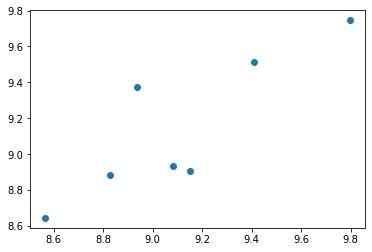

In [100]:
plt.scatter(predicted,actual)

In [101]:
dataset_norm = X_scaler.transform(arr)

In [102]:
pred = model.predict(dataset_norm)

In [103]:
act = arr2

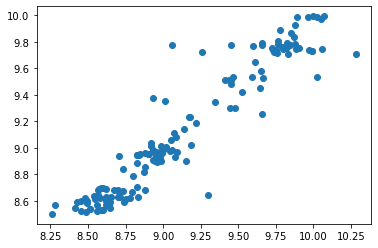

In [104]:
plt.scatter(pred, act)

In [106]:
import scipy.stats as st

In [113]:
pred[0]

array([8.80207], dtype=float32)

In [125]:
t_len = len(pred)
predi = []
actu = []
for i in range(t_len):
    predi.append(pred[i][0].astype(float))
    actu.append(act[i][0].astype(float))
    

In [141]:
pre = np.asarray(predi,dtype=float)

In [142]:
ac = np.asarray(actu,dtype=float)

In [143]:
x_axis = pre
y_axis = ac


In [144]:
correlation = st.pearsonr(x_axis,y_axis)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)


In [129]:
type(slope)

numpy.float64

In [130]:
slope, intercept, rvalue, pvalue, stderr

(0.8928683553195196,
 0.9701320696164295,
 0.9505574548841049,
 4.322670270494669e-79,
 0.023660125713542226)

0.9701320696164295

The correlation between both factors is 0.95
The linear regression equation is y = 0.89286836x + 0.97


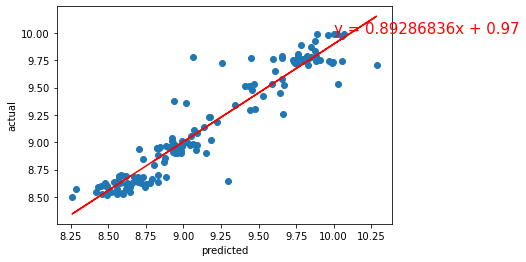

In [151]:
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,8)) + "x + " + str(round(intercept,2))
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,10),fontsize=15,color="red")
plt.xlabel('predicted')
plt.ylabel('actual')
print(f"The correlation between both factors is {round(correlation[0],2)}")
print(f'The linear regression equation is {line_eq}')
plt.show()

In [85]:
from prophet import Prophet


ModuleNotFoundError: No module named 'prophet'

In [152]:
loss, mae, mse = model.evaluate(X_val_scaled, y_val)

1/1 [==============================] - 0s 24ms/step - loss: 0.0429 - mean_absolute_error: 0.1606 - mean_squared_error: 0.0429


In [153]:
loss

0.04285820946097374

In [154]:
mae

0.16056469082832336

In [155]:
mse

0.04285820946097374

In [158]:
pip install plotly


  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [160]:
import plotly
import fbprophet
from fbprophet import Prophet

In [161]:
m = Prophet()

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [162]:
import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

ImportError: DLL load failed while importing _api: The specified module could not be found.

In [163]:
import fbprophet
print(fbprophet.__version__)

0.7.1


In [164]:
conda install libpython m2w64-toolchain -c msys2

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip uninstall fbprophet

In [ ]:
pip uninstall pystan